# INTERVIEW

https://www.kaggle.com/datasets/shuyangli94/interview-npr-media-dialog-transcripts

In [41]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

### Lendo dados dos episodeos

In [43]:
episodes = pd.read_csv('../data/00_raw/interview/original/episodes.csv')
episodes.episode_date = episodes.episode_date.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))
episodes.head()

,id,program,title,episode_date
0,98814,Morning Edition,Senate Ushers In New Year With 'Fiscal Cliff' ...,2013-01-01
1,98824,Morning Edition,Cheap Bubbly Or Expensive Sparkling Wine? Look...,2012-12-31
2,98821,Morning Edition,U.S. Gas Prices Reach Record Level In 2012,2013-01-01
3,98806,Morning Edition,House Approves 'Fiscal Cliff' Measure,2013-01-02
4,98823,Morning Edition,The Fiscal Cliff: A Love Story,2012-12-31
...,...,...,...,...
105843,98839,All Things Considered,"With Malaysia Airlines Crash, A Loss For AIDS ...",2014-07-19
105844,98840,All Things Considered,"The Israeli-Palestinian Conflict, Remixed And ...",2014-07-19
105845,98842,All Things Considered,"As Superheroes Go Mainstream, Comic Cons Get C...",2014-07-19
105846,98833,All Things Considered,"Despite California's Drought, Taps Still Flowi...",2014-07-20


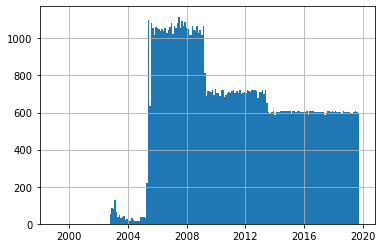

In [44]:
episodes.episode_date.hist(bins=200)
plt.show()

### Vamos usar os dados depois de 2010

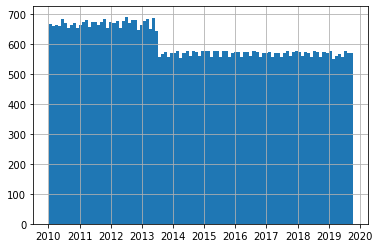

In [45]:
episodes = episodes[episodes.episode_date>datetime.datetime.strptime('2010',"%Y")]
episodes.episode_date.hist(bins=100)
plt.show()

### Lendo os dados de entrevista

In [46]:
interview = pd.read_csv('../data/00_raw/interview/original/utterances-2sp.csv')
interview.head()

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance
0,1,1,0,0,0,True,The impeachment inquiry picks up tomorrow wher...
1,1,1,1,0,0,True,"Just this morning, the lawyer for the whistleb..."
2,1,1,2,0,0,True,There's are a lot of moving parts.
3,1,1,3,0,0,True,"Fortunately, NPR's Mara Liasson is here to help."
4,1,2,0,0,0,True,Good morning.


In [47]:
interview = interview[
    (interview.is_host==False)
    & (interview.episode.isin(episodes.id.unique()))
]
len(interview)

443184

In [48]:
# exclui episodeos em que depois de selecionar somente o entrevistado (acima) 
# o speaker order é duplicado considerando que somente deveriam existir 2 pessoas na conversa

more_than_one = interview[['episode','speaker_order']].drop_duplicates()['episode'][interview[['episode','speaker_order']].drop_duplicates()['episode'].duplicated()]
interview = interview[~ interview.episode.isin(more_than_one)]
len(interview)

438458

### Lendo os dados dos episodeos

In [49]:
all_episodes = pd.read_csv('../data/00_raw/interview/original/utterances.csv')
all_episodes.head()

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."


### Obtendo os Speakers

In [50]:
speakers = all_episodes[all_episodes.episode.isin(interview.episode.unique())][['episode','speaker']].drop_duplicates()
speakers.speaker = speakers.speaker.str.lower()
speakers = speakers[~ speakers.speaker.str.contains('_no_speaker')]

speakers.groupby('episode').count().query('speaker > 2')

,speaker
episode,


In [51]:
speakers[speakers.speaker.str.contains('host')].episode.nunique()

13423

### Obtendo os dados de guests (covidados) a partir dos speakers

In [52]:
guests = speakers[~speakers.speaker.str.contains('host')]
guests.episode.nunique()

13416

In [53]:
guests.groupby('episode').count().query('speaker > 1')

,speaker
episode,


### Cria DF de sentenças usando os dados que vem de interview e guests

In [54]:
print(len(interview))
sentences = interview.merge(guests)[['episode','episode_order','turn_order','utterance','speaker']]
print(len(sentences))

438458
438249


In [55]:
sentences['utterance_id'] = sentences[['episode','episode_order','turn_order']].apply(lambda x: '_'.join(x.values.astype(str)), axis=1)
sentences = sentences.drop(columns=['episode','episode_order','turn_order'])
sentences.head()

,utterance,speaker,utterance_id
0,"Good morning, Lulu.","mara liasson, byline",1_3_0
1,"Well, the latest is that the lawyer for the fi...","mara liasson, byline",1_5_0
2,The first whistleblower only had second and th...,"mara liasson, byline",1_5_1
3,We also know that there are subpoenas for Whit...,"mara liasson, byline",1_5_2
4,We don't know how cooperative the administrati...,"mara liasson, byline",1_5_3


### A partir do DF de sentenças com a info do covidado e das senteças, precisamos classificar os convidados por raça e genero. Para isso vamos usar dados da wikipedia para direcionar as buscas.

In [56]:
import wikipedia
from tqdm import tqdm
import pickle
import random
tqdm.pandas()

#### Antes analisamos quantas senteças cada usuario falou e pegamos somente aqueles que tem entre 15 e 100 sentenças. Isso irá diminuir o tempo de execução da coleta da wikipedia

In [59]:
s_num = sentences.groupby('speaker',as_index=False).count().rename(columns={'utterance':'num'})[['speaker','num']]
s_num['speaker_processed'] = s_num.speaker.apply(lambda x: x.split(',')[0].split('(')[0].rstrip())
s_num = s_num.rename(columns={'speaker':'speaker_original', 'speaker_processed':'speaker'})
s_num.head()

,speaker_original,num,speaker
0,a,38,a
1,a e dick howard,27,a e dick howard
2,a lot of people are asking the paris city gove...,5,a lot of people are asking the paris city gove...
3,a martinez,3,a martinez
4,"a martinez, byline",43,a martinez


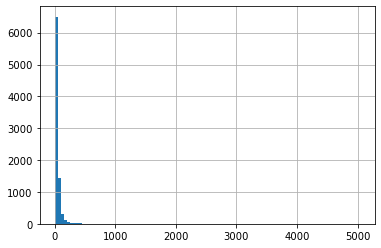

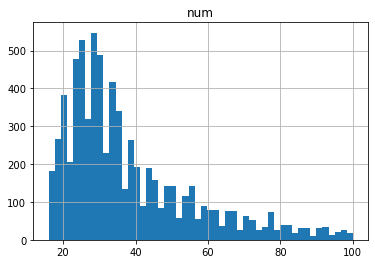

In [60]:
s_num.num.hist(bins=100)
plt.show()

s_num[(s_num.num>15) & (s_num.num<=100)].hist(bins=50)
plt.show()

s_num_cut = s_num[(s_num.num>15) & (s_num.num<=100)]

### Coleta os dados da Wikipedia

Deixar comentado para não executar atoa. Os dados são salvos e lidos na proxima celula.

In [ ]:
# wiki_data = {}
# for s in tqdm(s_num_cut.speaker.unique()):
#     try:
#         w = wikipedia.page(s)
#         wiki_data[s] = w
#     except:
#         continue

# with open("../data/wiki_data_cut.pkl", "wb") as pkl_handle:
# 	pickle.dump(wiki_data, pkl_handle)

In [ ]:
with open("../data/wiki_data_cut.pkl", "rb") as pkl_handle:
	wiki_data = pickle.load(pkl_handle)   

#### black_spkrs é um nome ruim pra esse DF, mas ele guarda os dados dos convidados que tem pagina na wikipedia

In [61]:
black_spkrs = s_num_cut.groupby('speaker',as_index=False).sum()[['speaker','num']]
black_spkrs = black_spkrs[black_spkrs.speaker.isin(wiki_data.keys())]
black_spkrs.head()

,speaker,num
0,a,38
1,a e dick howard,27
2,a martinez,43
5,aaron neville,52
10,abby finkenauer,34


#### Criamos uma coluna com as categorias que a wikipedia atribui a cada convidado

Esses dados tambem são salvos pois demoram muito para obter

In [64]:
# black_spkrs['categories'] = black_spkrs.speaker.progress_apply(lambda x: wiki_data[x].categories)
# black_spkrs.head()

In [ ]:
# black_spkrs.to_csv('../data/black_speakers_categories.csv', index=False)

In [65]:
black_spkrs = pd.read_csv('../data/black_speakers_categories.csv')

In [66]:
black_spkrs.categories = black_spkrs.categories.astype(str).str.lower()
black_spkrs['url'] = black_spkrs.speaker.progress_apply(lambda x: wiki_data[x].url)

#### Novo DF é definido contendo somente dados de convidados que contenham 'black' ou 'afric' em alguma das categorias da wikipedia. A partir desse df fazemos a classificação. Essa classificação é salva em um dicionario e por fim salva num CSV.

In [68]:
black_spkrs_cut = black_spkrs[black_spkrs.categories.str.contains('black') | black_spkrs.categories.str.contains('afric')]

In [69]:
black_spkrs_cut = black_spkrs_cut.sample(frac=1)

In [70]:
i = 160
black_spkrs_cut.iloc[i:i+10]

,speaker,num,categories,url
2339,lianne la havas,64,"['1989 births', '21st-century black british wo...",https://en.wikipedia.org/wiki/Lianne_La_Havas
2674,michael donkor,57,"['1985 births', '21st-century british male wri...",https://en.wikipedia.org/wiki/Michael_Donkor
950,dean baquet,33,"['1956 births', '20th-century african-american...",https://en.wikipedia.org/wiki/Dean_Baquet
1837,joanne barbara,57,"['1947 births', 'activists from new york (stat...",https://en.wikipedia.org/wiki/Assata_Shakur
3278,ms. peggy orenstein,52,"['1952 births', 'african-american academics', ...",https://en.wikipedia.org/wiki/Carla_Hayden
4492,tree sampson,21,"['1918 births', '2013 deaths', '20th-century m...",https://en.wikipedia.org/wiki/Nelson_Mandela
3510,percival everett,44,"['1956 births', '20th-century african-american...",https://en.wikipedia.org/wiki/Percival_Everett
3853,riley starks,33,"['1965 births', '20th-century african-american...",https://en.wikipedia.org/wiki/John_Starks
3380,nicole auerbach,31,"['1979 births', '21st-century american guitari...",https://en.wikipedia.org/wiki/Dan_Auerbach
3135,mr. rory stewart,48,"['1973 births', '20th-century british army per...",https://en.wikipedia.org/wiki/Rory_Stewart


In [71]:
black_spkrs_cut[black_spkrs_cut.speaker=='freeman hrabowski iii'].url.iloc[0]

'https://en.wikipedia.org/wiki/Freeman_A._Hrabowski_III'

In [72]:
m = 'm'
f = 'f'

black_clasifications = {
    'governor deval patrick': m,
    'lianne la havas': f,
    'latoya ruby frazier': f,
    'zandria robinson': f,
    'district attorney kenneth thompson': m,
    'jonathan capehart': m,
    'marc morial': m,
    'mr. yohannes haile-selassie': m,
    'jamelle bouie': m,
    'zinzi clemmons': f,
    'darrick hamilton': m,
    'mohammed fairouz': m,
    'teju cole': m,
    'darcel clark': f,
    'julius thomas': m,
    'elijah cummings': m,
    'attica locke': f,
    'sam sanders': m,

    'sho baraka': m,
    'nikuyah walker': f,
    'seth jones': m,
    'jim zion': m,
    'john ridley': m,
    'craig david': m,
    'audie cornish': f,
    'janelle bynum': f,
    'alondra nelson': f,
    'general colin powell': m,
    'anquan boldin': m,
    'sharon weston broome': f,
    'sheila jackson lee': f,
    'michael donkor': m,
    'hank johnson': m,
    'goldie taylor': f,
    'farai chideya': f,
    'josh green': m,
    'diran adebayo': m,
    'valerie jarrett': f, #?
    'kevyn orr': m,
    'alexis mcgill johnson': f,
    'carmen twillie ambar': f,

    'aaron neville': m,
    'thomas hollywood': m,
    'clarence page': m,
    'colion noir': m,
    'charlayne hunter': f,
    'meshell ndegeocello': f,
    'larycia hawkins': f,
    'alysia montano': f,
    'stephen henderson': m,
    'eleanor holmes norton': f,
    'caron butler': m,
    'helen oyeyemi': f,
    'alderman antonio french': m,

    'rachel swarns': f,
    'jamaica kincaid': f,
    'sarah m broom': f,
    'dorothy roberts': f,
    'professor melissa harris-lacewell': f,
    'olivia hooker': f,
    'helene cooper': f,
    'john lewis': m,
    'david o brown': m,
    'jemele hill': f,
    'marilyn nelson': f,
    'david price': m,
    'marshall shepherd': m,
    'percival everett': m,
    'esi edugyan': f,
    'professor margaret burnham': f,

    'kurt schmoke': m,
    'fawn weaver': f,
    'michael eric dyson': m,
    'fred luter': m,
    'jason wright': m,
    'harriet washington': f,
    'freeman hrabowski iii': m,
    'walter kimbrough': m,
    'darnell hunt': m,
    'gwen carr': f,
    'dr. susan rice': f,
    'the-dream': m,
    'rokhaya diallo': f,
    'tracy k smith': f,
}

In [73]:
black_df = pd.DataFrame.from_dict(black_clasifications,orient='index').reset_index().rename(columns={0:'gender','index':'speaker'})
black_df['race'] = 'black'
black_df = black_df.merge(s_num[['speaker_original','speaker']],how='left')
black_df.head()

,speaker,gender,race,speaker_original
0,governor deval patrick,m,black,"governor deval patrick (democrat, massachusetts)"
1,lianne la havas,f,black,lianne la havas
2,latoya ruby frazier,f,black,latoya ruby frazier
3,zandria robinson,f,black,zandria robinson
4,district attorney kenneth thompson,m,black,district attorney kenneth thompson


In [74]:
#duplicates
black_df[black_df.speaker.duplicated(keep=False)]

,speaker,gender,race,speaker_original
22,john ridley,m,black,john ridley
23,john ridley,m,black,"john ridley, byline"
50,stephen henderson,m,black,stephen henderson
51,stephen henderson,m,black,"stephen henderson, byline"


In [75]:
black_df.drop_duplicates('speaker').groupby('gender').count()

,speaker,race,speaker_original
gender,,,
f,40,40,40
m,44,44,44


In [76]:
# salva o dataframe com as classificações de pessoas pretas
black_df.to_csv('../data/interview_black_speakers.csv',index=False)

# White
O mesmo processo mas para pessoas brancas

In [77]:
probably_white = black_spkrs[ ~ black_spkrs.speaker.isin(black_spkrs_cut.speaker)]
probably_white = probably_white.sample(frac=1)
probably_white

,speaker,num,categories,url
2519,mark schlissel,21,"['1957 births', '20th-century american jews', ...",https://en.wikipedia.org/wiki/Mark_Schlissel
1680,jason glass,30,"['1979 births', '20th-century american male ac...",https://en.wikipedia.org/wiki/Jason_Momoa
510,brent trout,39,"['1976 births', '21st-century american politic...",https://en.wikipedia.org/wiki/Michelle_De_La_Isla
3532,peter kirkham,27,"['1974 births', 'articles with short descripti...",https://en.wikipedia.org/wiki/Peter_Kirkham
4375,thomas gouttiere,27,"['1890 establishments in california', '2005 di...",https://en.wikipedia.org/wiki/Unocal_Corporation
...,...,...,...,...
2754,mike murphy,46,"['1941 births', 'all wikipedia articles writte...",https://en.wikipedia.org/wiki/Mike_Murphy
4154,shannon sedgwick davis,37,"['cs1 maint: url-status', 'living people', 'ye...",https://en.wikipedia.org/wiki/Shannon_Sedgwick...
2043,julia greenberg,32,"['1966 births', 'all blp articles lacking sour...",https://en.wikipedia.org/wiki/Robin_Goldwasser
1756,jennifer morgan,23,"['1971 births', '21st-century american busines...",https://en.wikipedia.org/wiki/Jennifer_Morgan


In [116]:
#apos classificar sem esse filtro, ja obtive um numero suficiente de homens entao com o filtro, escolhemos somente mulheres
i = 40
probably_white[probably_white.categories.str.lower().str.contains('female') | probably_white.categories.str.lower().str.contains('women')].iloc[i:i+10]

,speaker,num,categories,url
2078,kamin mohammadi,41,"['1970 births', 'articles with nkc identifiers...",https://en.wikipedia.org/wiki/Kamin_Mohammadi
2098,karoun demirjian,35,"['1982 births', '21st-century american guitari...",https://en.wikipedia.org/wiki/Karoun_Demirjian
3697,rachel held evans,54,"['1981 births', '2019 deaths', '21st-century a...",https://en.wikipedia.org/wiki/Rachel_Held_Evans
1758,jennifer pahlka,26,"['1969 births', '21st-century american women',...",https://en.wikipedia.org/wiki/Jennifer_Pahlka
355,barbara lynch,59,"['21st-century american women', 'american chef...",https://en.wikipedia.org/wiki/Barbara_Lynch_(r...
1751,jennifer horn,25,"['1964 births', '20th-century american journal...",https://en.wikipedia.org/wiki/Jennifer_Horn
505,brenda martinez,45,"['1987 births', '21st-century american women',...",https://en.wikipedia.org/wiki/Brenda_Martinez
582,carla power,21,"['21st-century american non-fiction writers', ...",https://en.wikipedia.org/wiki/Carla_Power
2368,lisa gornick,33,"['1970 births', '20th-century lgbt people', '2...",https://en.wikipedia.org/wiki/Lisa_Gornick
1545,hope solo,87,"['1981 births', ""2007 fifa women's world cup p...",https://en.wikipedia.org/wiki/Hope_Solo


In [117]:
probably_white[probably_white.speaker=='barbara lynch'].iloc[0].url

'https://en.wikipedia.org/wiki/Barbara_Lynch_(restaurateur)'

In [129]:
white_classifications = {
    'andrew chamberlain': f,
    'reese witherspoon': f,
    'karoun demirjian': f,
    'rachel held evans': f,
    'jennifer pahlka': f,
    'barbara lynch': f,
    'jennifer horn': f,
    'carla power': f,
    'lisa gornick': f,


    'deputy finance minister jens spahn': m,
    'dr. david morrison': m,
    'neil frank': m,
    'frederick schauer': m,
    'rebecca stott': f,
    'former secretary of defense william perry': m,
    'diane roberts': f,
    'tom colicchio': m,
    'burton malkiel': m,
    'steve cohen': m,
    'thomas pierce': m,
    'james comer': m,
    'julissa arce': f,
    'chris murphy': m,
    'mark osler': m,
    'jay caspian kang': m,
    'klint kesto': m,
    'rebecca traister': f,
    'tristan harris': m,
    'jeanne shaheen': f,
    'mark rozell': m,
    
    'kathy gannon': f,
    'christie aschwanden': f,
    'juleen zierath': f,
    'jennifer ouellette': f,
    'wendy doniger': f,
    'john faso': m,
    'michelle fields': f,
    'bernard wasserstein': m,
    'victoria martin': f,
    'john rizzo': m,
    'leonard lance': m,
    'grant wahl': m,
    'john luther adams': m,
    'joshua keating': m,
    'diane roberts': f,
    'john carreyrou': m,
    'professor michael gerhardt': m,
    'morgan downey': m,
    'zachary lazar': m,
    'tom fox': m,
    'stephen townsend': m,
    'senator carl levin': m,

    'andrew walker': m,
    'jennifer horn': m,
    'stuart bowen': m,
    'richard cordray': m,
    'sean trende': m,
    'nancy mceldowney': f,
    'gretchen morgenson': f,
    'roger scully': m,
    'sean trende': m,
    'nancy mceldowney': f,
    'craig whitlock': m,
    'elaine duke': f,
    'rachel browne': f,
    'tom foreman': m,
    'richard clarke': m,
    'steve mccurry': m,
    'steve mccurry': m,
    'tom kent': m,
    'elliot goldenthal': m,
    'eric shinseki': m,

    'deborah blum': f,    

    'ilyana kuziemko': f,
    'diane douglas': f,
    'louise erdrich': f,
    'kim gandy': f,
    'mayor nan whaley': f,
    'helen rosner': f,
    'martha mendoza': f,
    'professor julia clarke': f,
    'kelly mcbride': f,
    'karen dawisha': f,
    'marilyn tavenner': f,
    'dionne searcey': f,
    'jennifer michael hecht': f,
    'emily dreyfuss': f,
    'micheline calmy-rey': f,
    'governor chris gregoire': f,
    'natalie babbitt': f,
    'ann selzer': f,
}

In [130]:
white_df = pd.DataFrame.from_dict(white_classifications,orient='index').reset_index().rename(columns={0:'gender','index':'speaker'})
white_df['race'] = 'white'
white_df = white_df.merge(s_num[['speaker_original','speaker']],how='left')
white_df.head()

,speaker,gender,race,speaker_original
0,andrew chamberlain,f,white,andrew chamberlain
1,reese witherspoon,f,white,reese witherspoon
2,karoun demirjian,f,white,karoun demirjian
3,rachel held evans,f,white,rachel held evans
4,jennifer pahlka,f,white,jennifer pahlka


In [131]:
#duplicates
white_df[white_df.speaker.duplicated(keep=False)]

,speaker,gender,race,speaker_original
15,diane roberts,f,white,diane roberts
16,diane roberts,f,white,"diane roberts, byline"


In [132]:
white_df.drop_duplicates('speaker').groupby('gender').count()

,speaker,race,speaker_original
gender,,,
f,43,43,43
m,43,43,43


In [133]:
white_df.to_csv('../data/interview_white_speakers.csv',index=False)

# Juntandos todos dfs
Junta e salva os dados no caminho especificado

In [135]:
df = pd.concat([white_df,black_df])

In [136]:
#duplicates
df[df.speaker.duplicated(keep=False)]

,speaker,gender,race,speaker_original
15,diane roberts,f,white,diane roberts
16,diane roberts,f,white,"diane roberts, byline"
22,john ridley,m,black,john ridley
23,john ridley,m,black,"john ridley, byline"
50,stephen henderson,m,black,stephen henderson
51,stephen henderson,m,black,"stephen henderson, byline"


In [139]:
df.drop_duplicates('speaker').groupby(['race','gender']).count()

speaker  speaker_original
race  gender                           
black f            40                40
      m            44                44
white f            43                43
      m            43                43

In [141]:
df.to_csv('../data/00_raw/interview/classifications/all.csv',index=False)